#### Dataset/DataLoader

In [1]:
from myo_sam.dataset import MyoData
from torch.utils.data import DataLoader

In [2]:
dataset = MyoData("/Users/giorginozadze/Desktop/instance_sam/data/")
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [3]:
image, masks = next(iter(dataloader))

In [4]:
image.dtype, masks.dtype

(torch.float32, torch.float32)

In [73]:
# (B, C, H, W) image transformed
# (B, N, H, W) masks transformed
image.shape, masks.shape

(torch.Size([1, 3, 1024, 1024]), torch.Size([1, 47, 1024, 1024]))

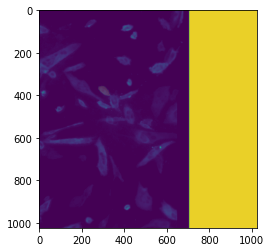

In [24]:
import matplotlib.pyplot as plt
plt.imshow(image[0, 0])
plt.imshow(masks[0, 10], alpha=0.1)


In [1]:
from segment_anything import sam_model_registry
model = sam_model_registry["vit_h"]("/Users//giorginozadze/Desktop/mask_generator/model/sam_vit_h_4b8939.pth")

In [2]:
params = [*model.named_parameters()]

In [17]:
[print(p[0]) for p in params[457:461]]
print(params[472][0])

prompt_encoder.point_embeddings.0.weight
prompt_encoder.point_embeddings.1.weight
prompt_encoder.point_embeddings.2.weight
prompt_encoder.point_embeddings.3.weight
prompt_encoder.no_mask_embed.weight


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


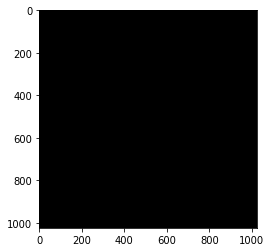

In [11]:
from segment_anything.modeling import sam
plt.imshow(model.preprocess(masks[0][0]).permute(1, 2, 0))

(-0.5, 1023.5, 1023.5, -0.5)

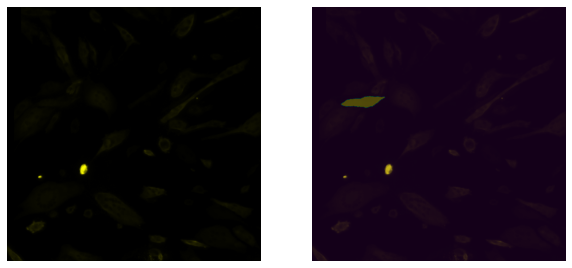

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image[0].permute(1, 2, 0))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(image[0].permute(1, 2, 0))
plt.imshow(masks[0][16], alpha=0.3)
plt.axis('off')

#### Training Algorithm

In [82]:
import torch
from typing import Union
from myo_sam.utils import (
    sample_initial_points,
    sample_points_from_error_region
)

# modify gt_mask from above for testing purposes
modified: torch.Tensor = masks[0][16].clone()
modified[350:450, 0:200] = 0
modified[350:450, 200:250] = 1

def predict_masks_fake(
    img_embeddings: torch.Tensor,
    point_prompt: Union[tuple[int, int], None]=None,
    mask_logits: Union[torch.Tensor, None]=None,
):
    B = len(img_embeddings)
    logits = torch.rand(B, 1, 1024, 1024)
    # (B, 1, 1024, 1024)
    masks = torch.repeat_interleave(
        modified.unsqueeze(0).unsqueeze(0), B, axis=0
    )
    return logits, masks

def run_training_algo_batch(
    img_embeddings: torch.Tensor, # (B, 256, 64, 64)
    gt_masks: torch.Tensor, # (B, 1, 1024, 1024)
    its: int=8
):
    point_test = []
    B, _, _, _ = gt_masks.shape
    # Sample initial points ([B, 1, 2], [B, 1])
    initial_points = sample_initial_points(gt_masks)
    point_test.append(initial_points)
    # Predict mask (B, 1, 1024, 1024)
    logits, pred_masks_torch = predict_masks_fake(
        img_embeddings, initial_points
    )

    # Only mask step
    only_mask_step = torch.randint(1, its, (1, ))

    # Error Region
    for i in range(its+2):
        # Sample a point prompt from the error region (B, 1, 2), (B, 1)
        error_region_points = sample_points_from_error_region(
            gt_masks,
            pred_masks_torch
        )
        point_test.append(error_region_points)
        # Predict mask
        logits, pred_masks_torch = predict_masks_fake(
            img_embeddings,
            error_region_points,
            mask_logits=(
                logits if (i != only_mask_step or i != its + 1) else None
            )
        )
    return point_test

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color='green',
        marker='*',
        s=marker_size,
        edgecolor='white',
        linewidth=1.25
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color='red',
        marker='*',
        s=marker_size,
        edgecolor='white',
        linewidth=1.25
    ) 

In [83]:
image_embeddings = torch.rand(1, 256, 64, 64)
gt_masks = masks[0][16].unsqueeze(0).unsqueeze(0)

points = run_training_algo_batch(image_embeddings, gt_masks, its=8)

In [10]:
import torch
torch.randint(0, 2, (20, 20)).int()

tensor([[1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1],
        [0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0],
        [0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1],
        [0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0],
        [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1],
        [1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1],
        [0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1],
        [0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0],
        [0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1],
        [1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1],
        [1, 0, 1, 1,

((-0.5, 1023.5, 1023.5, -0.5), Text(0.5, 1.0, 'Error Region with Points'))

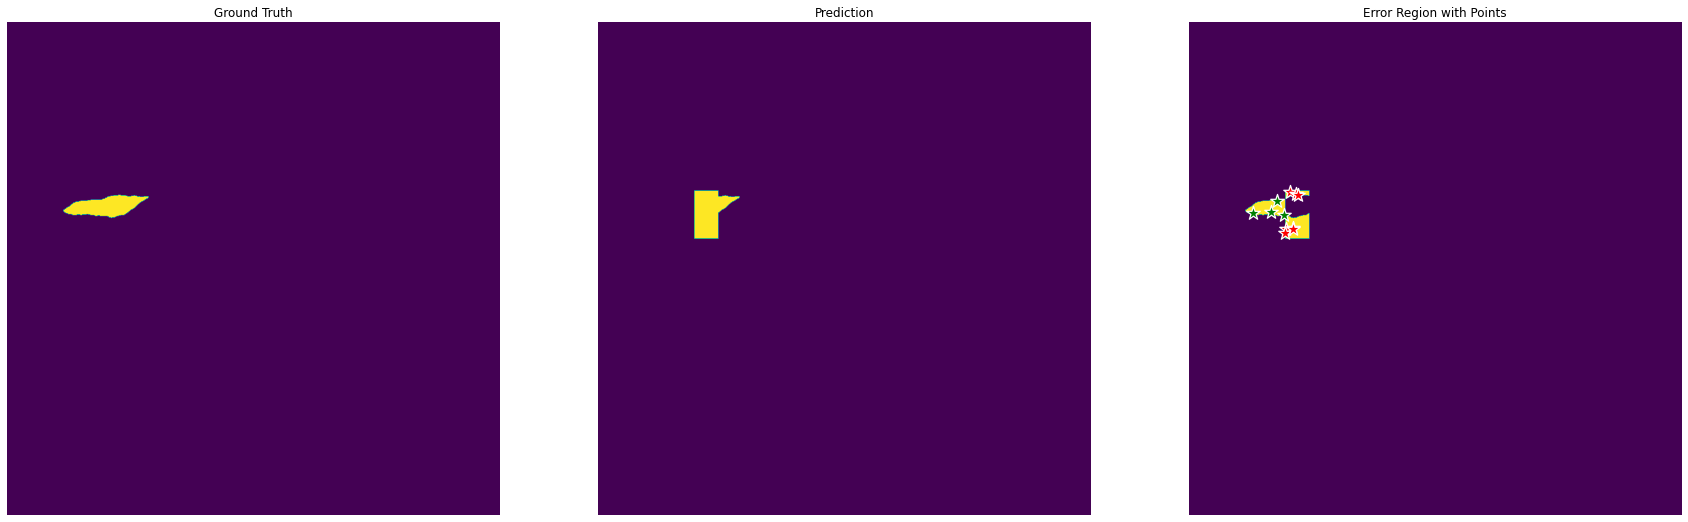

In [86]:
plt.figure(figsize=(30, 30))
plt.subplot(1, 3, 1)
plt.imshow(masks[0, 16])
plt.axis('off'), plt.title('Ground Truth')
plt.subplot(1, 3, 2)
plt.imshow(modified)
plt.axis('off'), plt.title('Prediction')
plt.subplot(1, 3, 3)
plt.imshow(torch.logical_xor(modified, masks[0, 16]))
[show_points(point[0], point[1], plt.gca(), 200) for point in points]
plt.axis('off'), plt.title('Error Region with Points')

In [23]:
from torch.optim.lr_scheduler import StepLR
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
scheduler = StepLR(optimizer, step_size=2, gamma=0.8)
for epoch in range(100):
    optimizer.step()
    scheduler.step()
    print(epoch, optimizer.param_groups[0]['lr'])

0 0.05
1 0.04000000000000001
2 0.04000000000000001
3 0.03200000000000001
4 0.03200000000000001
5 0.025600000000000008
6 0.025600000000000008
7 0.02048000000000001
8 0.02048000000000001
9 0.016384000000000006
10 0.016384000000000006
11 0.013107200000000006
12 0.013107200000000006
13 0.010485760000000005
14 0.010485760000000005
15 0.008388608000000004
16 0.008388608000000004
17 0.006710886400000004
18 0.006710886400000004
19 0.005368709120000003
20 0.005368709120000003
21 0.0042949672960000025
22 0.0042949672960000025
23 0.0034359738368000023
24 0.0034359738368000023
25 0.002748779069440002
26 0.002748779069440002
27 0.002199023255552002
28 0.002199023255552002
29 0.0017592186044416017
30 0.0017592186044416017
31 0.0014073748835532814
32 0.0014073748835532814
33 0.0011258999068426252
34 0.0011258999068426252
35 0.0009007199254741002
36 0.0009007199254741002
37 0.0007205759403792802
38 0.0007205759403792802
39 0.0005764607523034242
40 0.0005764607523034242
41 0.00046116860184273935
42 0.0